# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour
import pickle

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [ ]:
base_path = 'D:/Steven/Facultad/MAESTRIA/DMEyF/segmentacion/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_clase_ternaria.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

In [3]:
df_train = pd.read_csv(dataset_path + dataset_file)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [4]:
df_train = df_train[df_train['foto_mes']==202103]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [5]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [6]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [7]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

In [8]:
model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, random_state=17 )
model.fit(Xtrain_rf_imp, ytrain_rf)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,400
,min_weight_fraction_leaf,0.0
,max_features,20
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [9]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [10]:
md

array([[0.  , 0.99, 0.7 , ..., 0.95, 0.97, 0.99],
       [0.99, 0.  , 0.79, ..., 0.43, 0.16, 0.28],
       [0.7 , 0.79, 0.  , ..., 0.77, 0.84, 0.82],
       ...,
       [0.95, 0.43, 0.77, ..., 0.  , 0.48, 0.49],
       [0.97, 0.16, 0.84, ..., 0.48, 0.  , 0.3 ],
       [0.99, 0.28, 0.82, ..., 0.49, 0.3 , 0.  ]], shape=(3987, 3987))

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

d:\Steven\Facultad\MAESTRIA\DMEyF\segmentacion\.venv\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
d:\Steven\Facultad\MAESTRIA\DMEyF\segmentacion\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


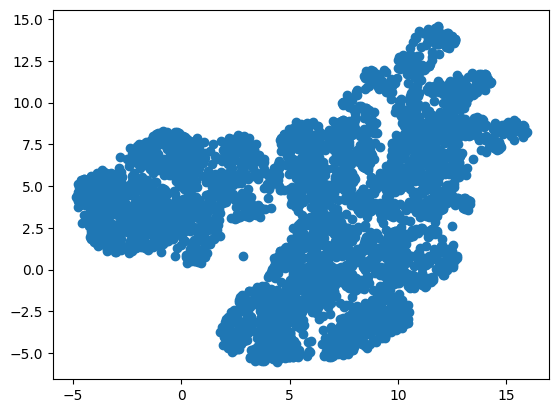

In [11]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=20,
  min_dist=0.77,
  learning_rate=0.05,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

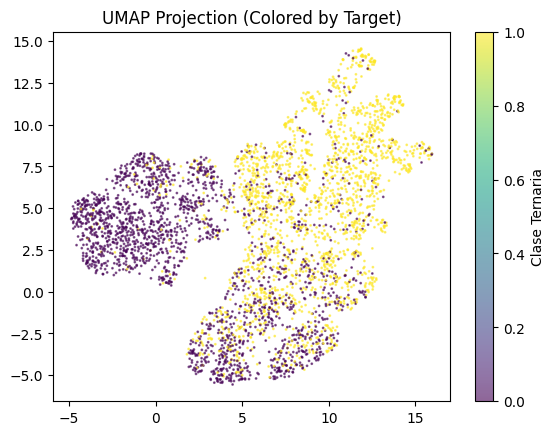

In [12]:
plt.scatter(
    embedding_rf[:, 0],
    embedding_rf[:, 1],
    c=ytrain_rf.values,
    cmap='viridis',
    s=1,
    alpha=0.6
)
plt.colorbar(label='Clase Ternaria')
plt.title('UMAP Projection (Colored by Target)')
plt.show()

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

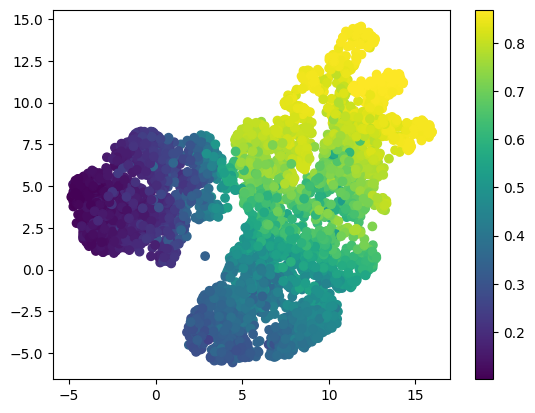

In [13]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

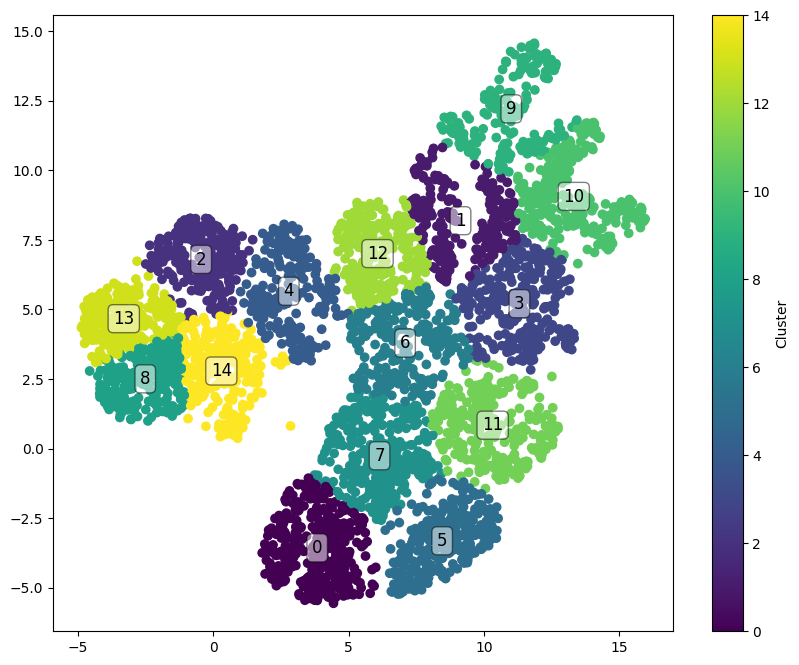

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=17, n_init=10)
clusters = kmeans.fit_predict(embedding_rf)


plt.figure(figsize=(10, 8))
plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster')

for cluster_label in sorted(np.unique(clusters)):
    cluster_points = embedding_rf[clusters == cluster_label]
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, ha='center', va='center', color='black',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))

plt.show()

Veamos cuales de los clientes de cada cluster son **bajas** y cuales **continuan** y la proba promedio del cluster

In [15]:
cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': ytrain_rf})

class_distribution_by_cluster = cluster_class_df.groupby('cluster')['original_class'].value_counts().unstack(fill_value=0)
cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster

print("Number of cases per class and average churn probability per cluster:")
print(class_distribution_by_cluster)

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0               255  104           0.332613
1                28  211           0.798933
2               223   22           0.218522
3                34  255           0.718491
4               192   42           0.376630
5               174   96           0.422101
6                69  191           0.649520
7               150  174           0.454290
8               226    5           0.149411
9                14  188           0.852838
10               15  265           0.842139
11              100  196           0.595295
12               41  217           0.760469
13              248    7           0.131659
14              231   14           0.214946


Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

Y exploramos las diferencias entre los clusters usando las **n** variables más importantes, usando en este caso la mediana


In [16]:
# sacar las features más importantes
importances = model.feature_importances_
feature_names = Xtrain_rf.columns
feature_importance_series = pd.Series(importances, index=feature_names)

feature_selected = feature_importance_series.sort_values(ascending=False)

n_top = 10 # cantidad de variables a evaluar.
top_overall_features = feature_selected.head(n_top).index.tolist()

cluster_series_aligned = pd.Series(clusters, index=Xtrain_rf.index)

cluster_median_values = {}

for cluster in sorted(np.unique(clusters)):
    cluster_indices = cluster_series_aligned[cluster_series_aligned == cluster].index
    cluster_data = Xtrain_rf.loc[cluster_indices, top_overall_features]

    # Usar el estadístico de su preferencia
    values = cluster_data.median()
    cluster_median_values[f'Cluster {cluster}'] = values

top_overall_features_df = pd.DataFrame(cluster_median_values)
display(top_overall_features_df)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14
ctrx_quarter,141.00,7.0,101.000,25.00,69.500,89.50,38.50,92.000,158.00,3.00,6.00,29.000,9.00,160.00,113.00
mpasivos_margen,1037.63,15.0,819.640,53.45,114.115,754.23,64.85,312.695,1109.62,0.91,0.04,440.985,13.39,1815.90,501.75
cpayroll_trx,0.00,0.0,1.000,0.00,1.000,0.00,0.00,0.000,1.00,0.00,0.00,0.000,0.00,1.00,1.00
mpayroll,0.00,0.0,93935.010,0.00,75648.280,0.00,0.00,0.000,112709.41,0.00,0.00,0.000,0.00,144044.90,81272.81
mcaja_ahorro,35238.87,0.0,48507.800,328.99,8683.855,9762.31,1255.02,12840.045,39968.84,0.00,0.00,14340.570,68.21,88062.10,18355.50
mautoservicio,14502.29,0.0,21139.040,0.00,4860.460,0.00,0.00,7294.760,22383.30,0.00,0.00,0.000,0.00,27568.60,5397.95
ctarjeta_debito_transacciones,7.00,0.0,11.000,0.00,3.000,0.00,0.00,5.000,10.00,0.00,0.00,0.000,0.00,14.00,3.00
mtarjeta_visa_consumo,34155.20,0.0,4637.200,3844.15,527.165,40760.15,1486.78,5153.655,36815.20,0.00,0.00,6475.805,0.00,31628.86,25375.70
Visa_msaldopesos,37047.04,0.0,4983.835,7535.80,3997.530,45319.56,5812.66,6126.125,41931.04,0.00,0.00,8682.180,0.00,31170.48,28031.95
mtransferencias_emitidas,23694.60,0.0,14662.500,0.00,3812.250,0.00,0.00,12688.925,30673.95,0.00,0.00,0.000,0.00,23694.60,7683.15


In [17]:
cluster_data

,ctrx_quarter,mpasivos_margen,cpayroll_trx,mpayroll,mcaja_ahorro,mautoservicio,ctarjeta_debito_transacciones,mtarjeta_visa_consumo,Visa_msaldopesos,mtransferencias_emitidas
1692,205,720.66,1,117999.10,20215.92,21911.78,18,33775.36,34176.44,15812.04
5133,43,458.44,1,15347.53,23819.43,0.00,0,11881.04,12023.62,7683.15
11481,176,1391.75,1,126845.87,39968.50,0.00,0,93858.40,94228.12,118195.17
12994,125,1914.85,2,371600.69,82728.27,0.00,0,9356.30,9164.77,105915.38
16895,58,5228.27,1,53813.50,358944.00,0.00,0,27609.62,27940.94,75094.04
...,...,...,...,...,...,...,...,...,...,...
961595,104,351.95,4,128382.50,26982.38,61496.00,21,14787.20,13989.18,19530.45
965887,80,209.69,3,133447.51,13040.69,0.00,0,5289.87,5293.67,586.50
966077,46,474.99,1,80777.48,26926.41,3274.55,2,14978.90,15158.65,914.94
971118,58,255.96,2,92408.94,9852.66,5196.39,4,18168.85,17892.98,7636.01


Otra de forma de explorar es graficar uno contra todos

In [18]:
def compare_cluster_stats(data, clusters, variable_name, target_cluster):

    cluster_series_aligned = pd.Series(clusters, index=data.index)

    variable_data = data[variable_name]

    target_cluster_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices] # Keep NaNs for counting

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices] # Keep NaNs for counting

    target_cluster_desc = target_cluster_data.dropna().describe()
    rest_desc = rest_data.dropna().describe()

    summary_df = pd.DataFrame({
        f'Cluster {target_cluster}': target_cluster_desc,
        f'Rest of Clusters': rest_desc
    })

    summary_df.loc['unique'] = [target_cluster_data.nunique(), rest_data.nunique()]
    summary_df.loc['missing'] = [target_cluster_data.isnull().sum(), rest_data.isnull().sum()]

    return summary_df

print(f"'mcaja_ahorro' - Cluster 0 vs. Rest")
compare_cluster_stats(Xtrain_rf, clusters, 'mcaja_ahorro', 0)

'mcaja_ahorro' - Cluster 0 vs. Rest


,Cluster 0,Rest of Clusters
count,3.590000e+02,3.628000e+03
mean,1.058918e+05,4.247948e+04
std,2.768056e+05,1.735640e+05
min,0.000000e+00,0.000000e+00
25%,1.425278e+04,9.205000e+00
50%,3.523887e+04,4.729610e+03
75%,8.390768e+04,3.015736e+04
max,2.782366e+06,4.787508e+06
unique,3.540000e+02,2.782000e+03
missing,0.000000e+00,0.000000e+00


Muy interesante... pero no hay una brújula que nos ayude a ver que variables comparar?

Acá un salvavidas: Crea un modelo que busca separar los clusters del resto de los datos y nos devuelven las variables más importantes de esa separación

In [19]:
important_features_by_cluster = {}

for cluster in sorted(np.unique(clusters)):
    print(f"Training model for Cluster {cluster} vs. Rest...")
    y_binary = (cluster_series_aligned == cluster).astype(int)

    model = RandomForestClassifier(n_estimators=100, random_state=17, class_weight='balanced') # Added class_weight for imbalanced data
    model.fit(Xtrain_rf_imp, y_binary)

    importances = model.feature_importances_
    feature_names = Xtrain_rf.columns

    indices = np.argsort(importances)[::-1]

    important_features_by_cluster[cluster] = [feature_names[i] for i in indices]


Training model for Cluster 0 vs. Rest...
Training model for Cluster 1 vs. Rest...
Training model for Cluster 2 vs. Rest...
Training model for Cluster 3 vs. Rest...
Training model for Cluster 4 vs. Rest...
Training model for Cluster 5 vs. Rest...
Training model for Cluster 6 vs. Rest...
Training model for Cluster 7 vs. Rest...
Training model for Cluster 8 vs. Rest...
Training model for Cluster 9 vs. Rest...
Training model for Cluster 10 vs. Rest...
Training model for Cluster 11 vs. Rest...
Training model for Cluster 12 vs. Rest...
Training model for Cluster 13 vs. Rest...
Training model for Cluster 14 vs. Rest...


Vemos las más importantes para un cluster

In [20]:
print(important_features_by_cluster[0])

['mpayroll', 'cpayroll_trx', 'mautoservicio', 'mpasivos_margen', 'ctarjeta_debito_transacciones', 'ctrx_quarter', 'Visa_msaldototal', 'mtarjeta_visa_consumo', 'Visa_msaldopesos', 'Visa_mpagospesos', 'ctarjeta_visa_transacciones', 'Visa_mconsumototal', 'Visa_mpagominimo', 'ccomisiones_otras', 'Visa_cconsumos', 'mcaja_ahorro', 'mactivos_margen', 'mcomisiones_otras', 'Visa_mconsumospesos', 'ctransferencias_recibidas', 'mtransferencias_recibidas', 'mtransferencias_emitidas', 'mcomisiones', 'ctransferencias_emitidas', 'chomebanking_transacciones', 'ccomisiones_mantenimiento', 'mcomisiones_mantenimiento', 'mttarjeta_visa_debitos_automaticos', 'mcuentas_saldo', 'mrentabilidad_annual', 'mpagomiscuentas', 'mcuenta_corriente', 'mcuenta_debitos_automaticos', 'cliente_edad', 'cpagomiscuentas', 'numero_de_cliente', 'Visa_fechaalta', 'mrentabilidad', 'Visa_Fvencimiento', 'mcaja_ahorro_dolares', 'Master_Fvencimiento', 'cliente_antiguedad', 'ctarjeta_visa_debitos_automaticos', 'mextraccion_autoservici

Y luego miramos los estadísticos

In [21]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpasivos_margen', 1)

,Cluster 1,Rest of Clusters
count,239.000000,3748.000000
mean,34.090711,1053.886969
std,44.749935,2957.537385
min,-115.530000,-4004.300000
25%,0.360000,39.577500
50%,15.000000,313.170000
75%,57.145000,996.430000
max,176.210000,62444.940000
unique,191.000000,3378.000000
missing,0.000000,0.000000


Es perfecto? **NO** pero es orientativo

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda
